## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

# Libraries for text preprocessing and analysis
import re,nltk,spacy,string
nlp=spacy.load("en_core_web_sm")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import nltk
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

# Libraries for model evaluation metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report



C:\Users\Hp\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Hp\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Hp\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
#Supress warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
#Opening JSON file 
#f = # Write the path to your data file and load it 
f = open("complaints.json")
  
#returns JSON object as  
#a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
#Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
#Check the shape of the database
df.shape

(78313, 22)

In [6]:
#print the column names
col_list=list(df.columns)
col_list

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [7]:
#learn the datatype of column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [8]:
#learn the stats of numeric data column score
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


### `Observation:` _score which is the only data column and has the data value 0.

In [9]:
#Inspect the number of missing values percentage
round(df.isna().sum()*100/78313,2)

_index                                0.00
_type                                 0.00
_id                                   0.00
_score                                0.00
_source.tags                         86.08
_source.zip_code                      8.63
_source.complaint_id                  0.00
_source.issue                         0.00
_source.date_received                 0.00
_source.state                         2.54
_source.consumer_disputed             0.00
_source.product                       0.00
_source.company_response              0.00
_source.company                       0.00
_source.submitted_via                 0.00
_source.date_sent_to_company          0.00
_source.company_public_response      99.99
_source.sub_product                  13.50
_source.timely                        0.00
_source.complaint_what_happened       0.00
_source.sub_issue                    59.12
_source.consumer_consent_provided     1.29
dtype: float64

In [10]:
#Assign new column names
#Removing "_" from column names
df.columns=[re.sub('^_','',col) for col in df.columns]

#Removing "source." from column names
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]

list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [11]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace=True)

In [12]:
#Check the number of missing values percentage
round(df.isna().sum()*100/78313,2)

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         86.08
zip_code                      8.63
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         2.54
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  13.50
timely                        0.00
complaint_what_happened      73.09
sub_issue                    59.12
consumer_consent_provided     1.29
dtype: float64

### `Observation:` ~73% of the values in Complaint_what_happen are blank

In [13]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

In [14]:
#Check new shape of database after dropping nan columns
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    #Make the text lowercase
    text=text.lower()    
    #Remove text in square brackets
    text=re.sub(r'\[.*?\]','',text)
    #Remove punctuation
    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)
    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [16]:
#Cleaning df['complaint_what_happened'] as it has large number of NA values.
df['complaint_what_happened']= df['complaint_what_happened'].apply(lambda x: clean_text(x))

In [17]:
#Write your function to Lemmatize the texts
def lemma_text(text):             
    # Initialize empty list to store lemmas
    lemma_list = []
    # Extract lemmas of given text and add to the list
    document = nlp(text)
    for word in document:
        lemma_list.append(word.lemma_)
    # return string converted form of the list of lemmas
    return " ".join(lemma_list)

In [18]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
# below code takes ~14 min to execute
df["lemmatized_complaint"] =  df.apply(lambda x: lemma_text(x['complaint_what_happened']), axis=1)

# View the dataframe
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name be xxxx xxxx and I apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in xx/xx/ and was...,Problem with rewards from credit card,Consent provided,I upgrade my xxxx xxxx card in xx / xx/ and be...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,"chase card was reported on xx/xx/. however, fr...",Information belongs to someone else,Consent provided,"chase card be report on xx / xx/. however , fr..."
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"on xx/xx/, while trying to book a xxxx xxxx ...",Information belongs to someone else,Consent provided,"on xx / xx/ , while try to book a xxxx xxxx ..."
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$.} i deposit ...,Funds not handled or disbursed as instructed,Consent provided,my grand son give I check for { $ . } I deposi...


In [19]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean=df[['complaint_what_happened','lemmatized_complaint']]

In [20]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr..."
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ..."
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...


In [21]:
#Write your function to extract the POS tags 
#Below code takes ~6 min to execute
def pos_tag(text):
  # Creating a textblob object
    text_blob = TextBlob(text)
    # extracting words with tags 'NN', joining them and return
    return ' '.join([ word for (word,tag) in text_blob.tags if tag == "NN"])

df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: pos_tag(x['lemmatized_complaint']), axis=1)

In [22]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘

In [23]:
#Write your code here to visualise the data according to the 'Complaint' character length
char_len=[len(x) for x in df_clean['complaint_POS_removed']]
char_len[:15]

[159, 101, 67, 414, 155, 7, 650, 582, 1164, 51, 27, 206, 118, 138, 620]

#### Find the top 40 words by frequency among all the articles after processing the text.

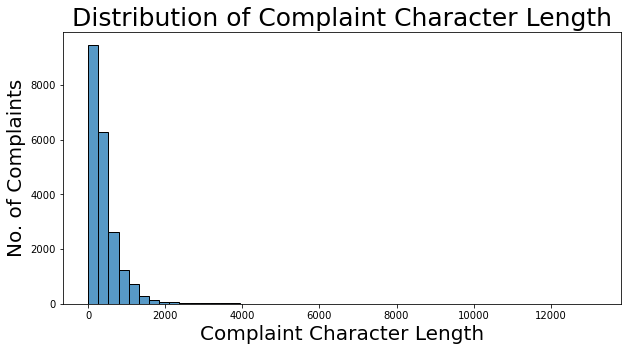

In [26]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
plt.figure(figsize=[10,5])
sns.histplot(data = char_len,bins=50)
plt.title('Distribution of Complaint Character Length', fontsize=25)
plt.xlabel('Complaint Character Length',size=20)
plt.ylabel('No. of Complaints',size=20)
plt.show()

In [25]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

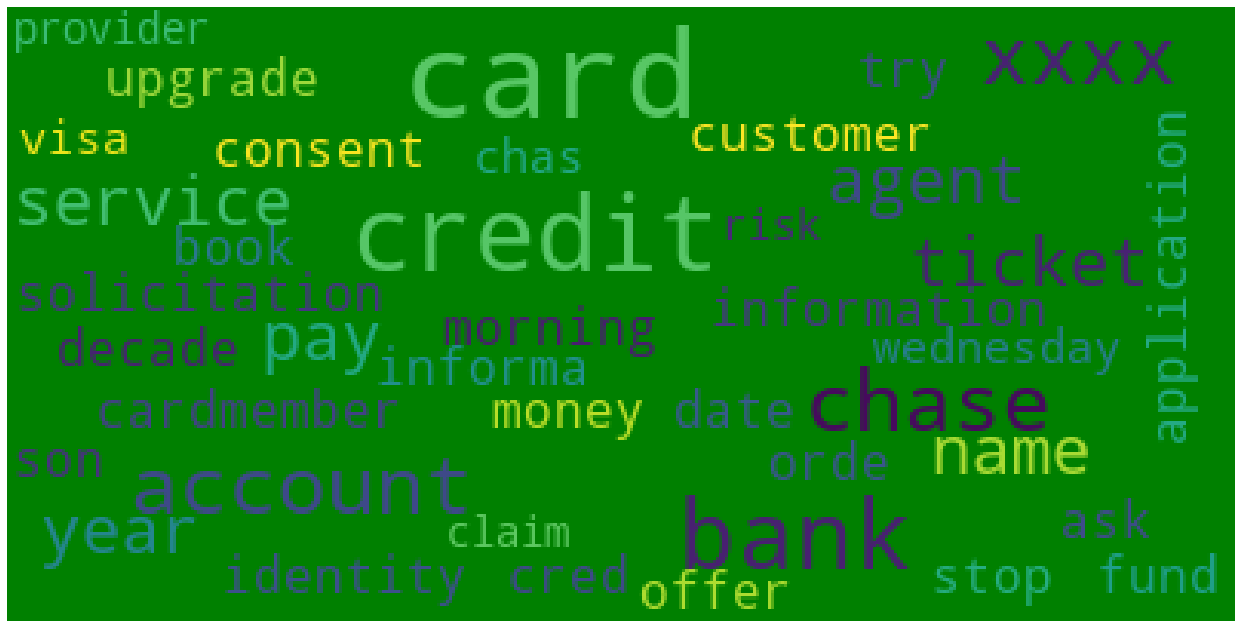

In [27]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='green',
                          stopwords=stop_words,
                          max_font_size=40,
                          max_words=40, 
                          random_state=42
                         ).generate(str(df_clean['Complaint_clean']))

fig = plt.figure(figsize=(22,18))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [28]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def top_unigram(text, n=30):
    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [29]:
#Print the top 10 words in the unigram frequency
top_common_words = top_unigram(df_clean['Complaint_clean'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,chase,49114
1,account,47918
2,xxxx,43314
3,credit,34302
4,card,29628
5,bank,28510
6,payment,21329
7,time,16304
8,charge,15151
9,day,13064


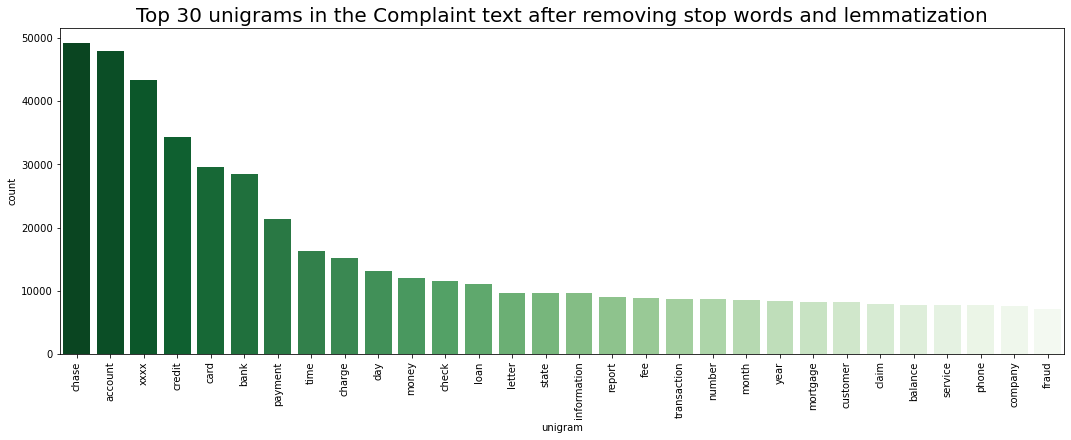

In [30]:
plt.figure(figsize=(18,6))
sns.barplot(x='unigram', y='count', data=df_unigram, palette="Greens_r")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [31]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def top_bigram(text, n=30):
    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [32]:
#Print the top 10 words in the bigram frequency
top_common_words = top_bigram(df_clean['Complaint_clean'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
df_bigram.head(10)

,bigram,count
0,credit card,12880
1,xxxx xxxx,6252
2,credit report,3972
3,customer service,3082
4,chase credit,3065
5,chase bank,2931
6,bank account,2784
7,account chase,2749
8,chase account,2595
9,account account,2323


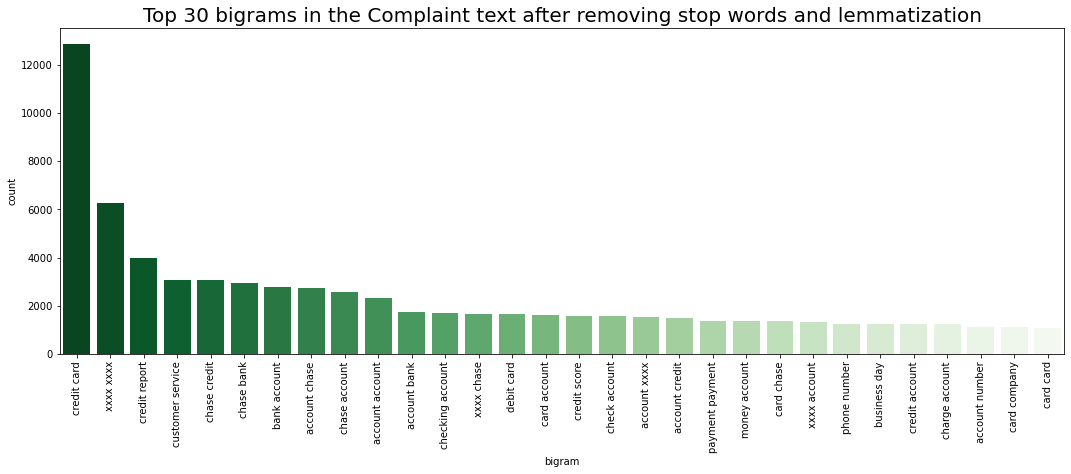

In [33]:
plt.figure(figsize=(18,6))
sns.barplot(x='bigram', y='count', data=df_bigram, palette="Greens_r")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [34]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def top_trigram(text, n=30):
    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [35]:
#Print the top 10 words in the trigram frequency
top_common_words = top_trigram(df_clean['Complaint_clean'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,chase credit card,2141
1,xxxx xxxx xxxx,1066
2,credit card account,1057
3,credit card company,995
4,credit card chase,672
5,credit card credit,510
6,inquiry credit report,482
7,charge credit card,430
8,account credit card,414
9,card credit card,383


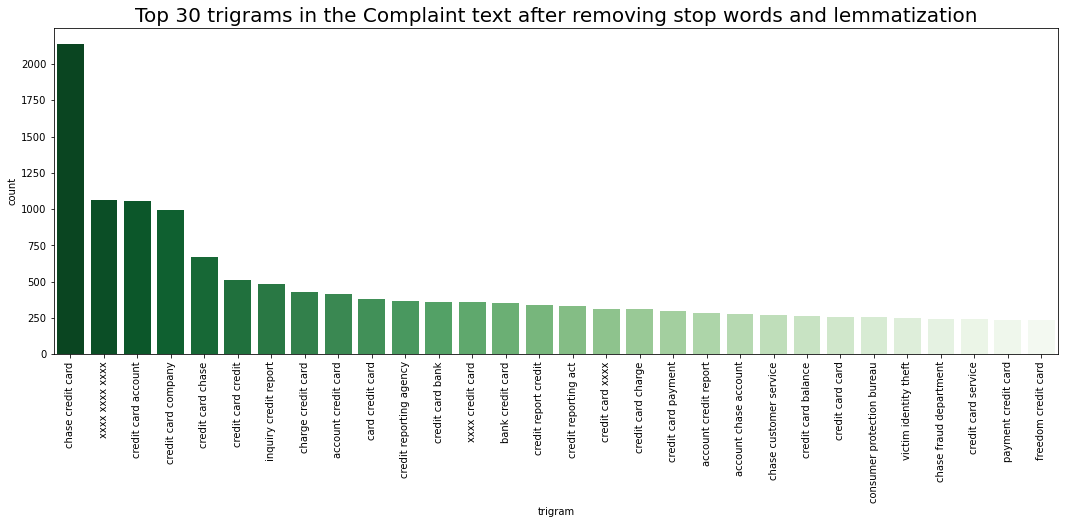

In [36]:
#Plot the top 30 trigrams
plt.figure(figsize=(18,6))
sns.barplot(x='trigram', y='count', data=df_trigram, palette="Greens_r")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

## `The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis.`

In [37]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [38]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [39]:
#Making a copy of df_clean
df_cleaner=df_clean.copy()

In [40]:
df_clean=df_cleaner.copy()

In [41]:
#Write your code here to initialise the TfidfVectorizer 
tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [42]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm=tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [43]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [44]:
# Making a copy of df_clean incase any of issue as it takes long time to run the above code
df_clean_copy =df_clean.copy()

In [45]:
#Load your nmf_model with the n_components i.e 5
num_topics = list(np.arange(5, 10, 1))

#keep the random_state =40
nmf_model = NMF(n_components=5,random_state=40)

In [46]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

7059

In [47]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR THE TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP 15 WORDS FOR THE TOPIC #0
['transfer', 'claim', 'checking', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'check', 'bank', 'account']


TOP 15 WORDS FOR THE TOPIC #1
['year', 'balance', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


TOP 15 WORDS FOR THE TOPIC #2
['mortgage', 'year', 'chase', 'credit', 'account', 'date', 'pay', 'time', 'day', 'auto', 'statement', 'fee', 'month', 'balance', 'payment']


TOP 15 WORDS FOR THE TOPIC #3
['company', 'refund', 'statement', 'time', 'service', 'claim', 'purchase', 'fraud', 'merchant', 'transaction', 'dispute', 'fee', 'chase', 'card', 'charge']


TOP 15 WORDS FOR THE TOPIC #4
['sale', 'house', 'bank', 'foreclosure', 'document', 'time', 'rate', 'letter', 'year', 'property', 'modification', 'chase', 'home', 'mortgage', 'loan']




In [48]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_result = nmf_model.transform(dtm)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)

array([0, 1, 1, ..., 3, 2, 2], dtype=int64)

In [49]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_result.argmax(axis=1)

In [50]:
#Check the dimention of the dataframe
df_clean.shape

(21072, 5)

In [51]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [52]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
17,with out notice j.p. morgan chase restricted m...,with out notice j.p . morgan chase restrict my...,j.p chase account debit card tuesday branch cu...,j.p chase account debit card tuesday branch cu...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xx...,mishandle account auto xxxx,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [53]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [54]:
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank Account services
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card or prepaid card
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,card application identity consent service cred...,Credit card or prepaid card
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card or prepaid card
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card or prepaid card
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call chas , my...",wednesday chas visa credit card provider claim...,wednesday chas visa credit card provider claim...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yr . I 've h...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...,Others


In [55]:
df_clean.shape

(21072, 5)

In [56]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [57]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,Bank Account services
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,Credit card or prepaid card
10,"chase card was reported on xx/xx/. however, fr...",Credit card or prepaid card
11,"on xx/xx/, while trying to book a xxxx xxxx ...",Credit card or prepaid card
14,my grand son give me check for {$.} i deposit ...,Bank Account services
...,...,...
78303,after being a chase card customer for well ove...,Credit card or prepaid card
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...",Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs. i've had ...,Others


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [58]:
#Write your code to get the Vector count
count_vector=CountVectorizer()

#Write your code here to transform the word vector to tf-idf
X_train_count=count_vector.fit_transform(training_data['complaint_what_happened'])

In [59]:
#Saving Word Vector on disk for later usage in modeling
import pickle
pickle.dump(count_vector.vocabulary_, open("count_vector.pkl","wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [60]:
# Write your code here to build any 3 models and evaluate them using the required metrics
def model_eval(y_test, y_pred, model_name):    
    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    # plot confusion matrix of the classifier
    plt.figure(figsize=(10,7))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Greens", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()
    return

In [61]:
#Transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transform= TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_count)

In [62]:
#Save TF-IDF on disk for later usage
pickle.dump(tfidf_transform, open("tfidf.pkl","wb"))

In [63]:
#Train-Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (15804, 27984)
y_train Shape: (15804,)
X_test Shape: (5268, 27984)
y_test Shape: (5268,)


# **Model 1: `Naive Bayes`**

In [64]:
#Import required library
from sklearn.naive_bayes import MultinomialNB

In [65]:
#Run the Multinomial Naive Bayes with default parameters
model_name = 'NAIVE BAYES'
nb = MultinomialNB()

nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [66]:
#Hyperparameter tuning for best result
#It takes around 5 minutes to run
from sklearn.model_selection import GridSearchCV

param_nb = {'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),'fit_prior':[True, False]}
grid_nb = GridSearchCV(estimator=nb, 
                       param_grid=param_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    5.0s finished


{'alpha': 0.1, 'fit_prior': False}


In [67]:
#Creating model with best hyperparameter
model_name = 'NAIVE BAYES'
nb_tuned = MultinomialNB(alpha=0.1,fit_prior=False)

nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = nb_tuned.predict(X_test)

In [68]:
#Calculate F1 Score of model using weighted average method
f1_nb = f1_score(y_test, y_pred_nb_tuned, average="weighted")
f1_nb

0.779394715096944

CLASSIFICATION REPORT for NAIVE BAYES

                             precision    recall  f1-score   support

      Bank Account services       0.78      0.83      0.81      1313
Credit card or prepaid card       0.80      0.75      0.78      1275
                     Others       0.83      0.84      0.84       917
    Theft/Dispute Reporting       0.66      0.64      0.65       561
              Mortgage/Loan       0.77      0.77      0.77      1202

                   accuracy                           0.78      5268
                  macro avg       0.77      0.77      0.77      5268
               weighted avg       0.78      0.78      0.78      5268



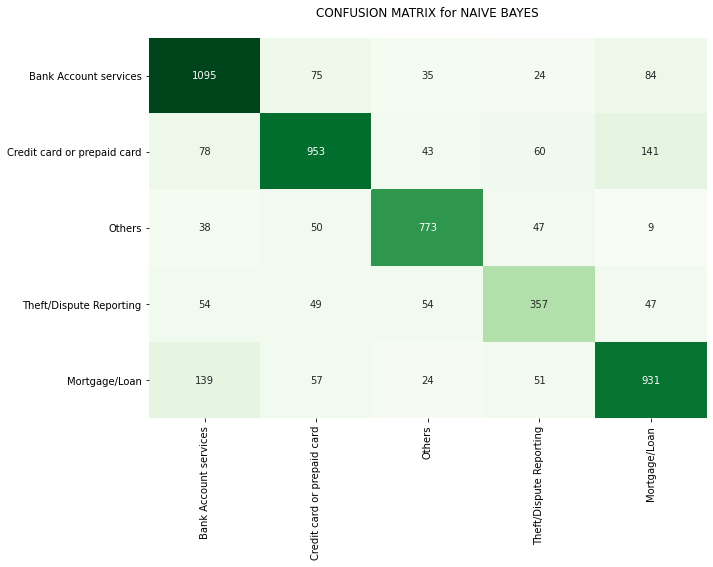

In [69]:
#Evaluate the Naive Bayes classifier
model_eval(y_test, y_pred_nb_tuned, model_name)

In [70]:
#Create a dataframe to store F1 Scores of all models we will build
f1_summary = pd.DataFrame([{'Model': 'Naive Bayes','F1 Score': round(f1_nb, 2)}])
f1_summary

,Model,F1 Score
0,Naive Bayes,0.78


# **Model 2: `Logistic Regression`**

In [71]:
#Import required library
from sklearn.linear_model import LogisticRegression

In [73]:
#Run the Logistic Regression model with default parameters
model_name = 'LOGISTIC REGRESSION'
lr = LogisticRegression(solver='liblinear') 

lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [74]:
#Hyperparameter tuning for best result
#It takes around 8 minutes to run
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=lr, 
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.4min finished


{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [75]:
#Creating model with best hyperparameter
lr_tuned = LogisticRegression(C=1, penalty='l1', solver='saga')

lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)

In [76]:
#Calculate F1 Score of tuned model using weighted average method
f1_lr = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr

0.9437613122170836

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.95      0.96      0.96      1313
Credit card or prepaid card       0.95      0.95      0.95      1275
                     Others       0.95      0.94      0.94       917
    Theft/Dispute Reporting       0.94      0.95      0.94       561
              Mortgage/Loan       0.93      0.92      0.92      1202

                   accuracy                           0.94      5268
                  macro avg       0.94      0.94      0.94      5268
               weighted avg       0.94      0.94      0.94      5268



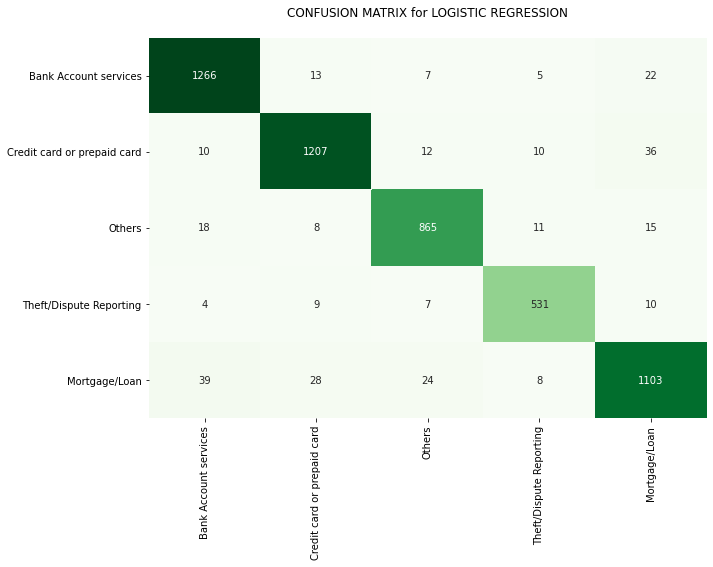

In [77]:
#Evaluate the tuned Logistic Regression classifier
model_eval(y_test, y_pred_lr_tuned, model_name)

In [78]:
#Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Logistic Regression', round(f1_lr, 2)]
f1_summary

,Model,F1 Score
0,Naive Bayes,0.78
1,Logistic Regression,0.94


# **Model 3: `Decision Tree`**

In [79]:
#Import required library
from sklearn.tree import DecisionTreeClassifier

In [80]:
#Run Decision Tree with default hyperparameters
model_name = 'DECISION TREE'
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
y_pred_dt =dt.predict(X_test)

In [81]:
#Hyperparameter tuning for best result
#It takes around 15 minutes to run
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],
    
}

grid_dt = GridSearchCV(estimator=dt, 
                       param_grid=param_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.4min finished


{'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 15}


In [82]:
#Creating model with best hyperparameter
dt_tuned = DecisionTreeClassifier(criterion='gini', max_depth=25, min_samples_leaf=15,)

dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)

In [83]:
#Calculate F1 Score of tuned model using weighted average method
f1_dt = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt


0.7954195700652748

CLASSIFICATION REPORT for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account services       0.79      0.83      0.81      1313
Credit card or prepaid card       0.83      0.82      0.82      1275
                     Others       0.80      0.84      0.82       917
    Theft/Dispute Reporting       0.78      0.77      0.78       561
              Mortgage/Loan       0.77      0.71      0.74      1202

                   accuracy                           0.80      5268
                  macro avg       0.79      0.79      0.79      5268
               weighted avg       0.80      0.80      0.80      5268



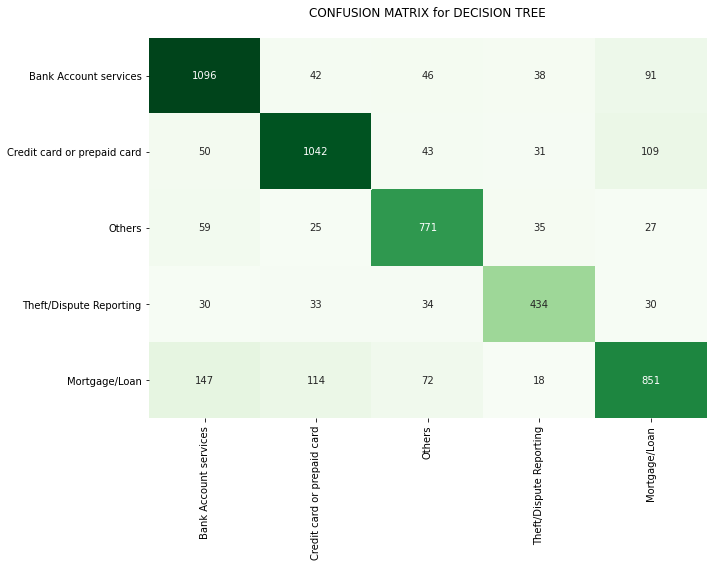

In [84]:
#Evaluate the tuned Decision Tree classifier
model_eval(y_test, y_pred_dt_tuned, model_name)

In [85]:
#Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Decision Tree', round(f1_dt, 2)]
f1_summary

,Model,F1 Score
0,Naive Bayes,0.78
1,Logistic Regression,0.94
2,Decision Tree,0.80


# **As per the F1 score of all the 3 models, `Logistic Regression` performs best with `F1 score : 0.94`**

## **Predicting topics via Logistic Regression on custom text**

In [86]:
#Function to predict a topic for custom text
def topic_predictor(text):    
    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    load_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    load_tfidf = pickle.load(open("tfidf.pkl","rb"))
    load_model = pickle.load(open("logreg_model.pkl","rb"))

    X_new_count = load_vec.transform(text)
    X_new_tfidf = load_tfidf.transform(X_new_count)
    prediction = load_model.predict(X_new_tfidf)

    return target_names[prediction[0]]

In [87]:
#Creating a dataframe of some random customer complaints
df_custom = pd.DataFrame({'complaints': ["Where are the bank branches in the city of Patna?",
    
                                         "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                         
                                         "I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  
                                         "How can I know my CIBIL score?",
                                         
                                         "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  
                                         "unwanted service activated and money deducted automatically "]})
df_custom

,complaints
0,Where are the bank branches in the city of Patna?
1,The bill amount of my credit card was debited ...
2,I can not get from chase who services my mortg...
3,How can I know my CIBIL score?
4,I want to open a salary account at your downto...
5,unwanted service activated and money deducted ...


In [88]:
#Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_custom['predicted topic'] = df_custom['complaints'].apply(lambda x: topic_predictor([x]))
df_custom

,complaints,predicted topic
0,Where are the bank branches in the city of Patna?,Bank Account services
1,The bill amount of my credit card was debited ...,Credit card or prepaid card
2,I can not get from chase who services my mortg...,Others
3,How can I know my CIBIL score?,Credit card or prepaid card
4,I want to open a salary account at your downto...,Bank Account services
5,unwanted service activated and money deducted ...,Bank Account services


# **# Thus based on above results we can conclude that the `Logistic Regression Model` is predicting well on `Custom Data`**